### Prepare Data for Modeling

In [8]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load features
df = pd.read_parquet('../data/processed/features_simple.parquet')

In [3]:
# Train/test split
train = df[df['GAME_DATE'] < '2024-01-01']
test = df[df['GAME_DATE'] >= '2024-01-01']

In [4]:
# Feature columns (simple set)
feature_cols = [
    'pts_last_3', 'pts_last_5',
    'reb_last_3', 'reb_last_5',
    'ast_last_3', 'ast_last_5',
    'min_last_3', 'min_last_5',
    'games_played'
]

In [5]:
X_train = train[feature_cols]
X_test = test[feature_cols]

### Train Ridge Regression for each target

In [6]:
results = {}

for target in ['PTS', 'REB', 'AST']:
    print(f"\n=== Training {target} ===")

    y_train = train[target]
    y_test = test[target]

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Ridge
    model = Ridge(alpha=1.0, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)

    # Metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Baseline comparison
    baseline_pred = test[f'{target.lower()}_last_5'].values
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    improvement = (baseline_mae - test_mae) / baseline_mae * 100

    results[target] = {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'test_rmse': test_rmse,
        'baseline_mae': baseline_mae,
        'improvement_pct': improvement,
        'predictions': y_pred_test,
        'actuals': y_test.values
    }

    print(f"Train MAE: {train_mae:.3f}")
    print(f"Test MAE: {test_mae:.3f} | RMSE: {test_rmse:.3f}")
    print(f"Baseline MAE: {baseline_mae:.3f}")
    print(f"Improvement: {improvement:+.1f}%")


=== Training PTS ===
Train MAE: 6.000
Test MAE: 6.478 | RMSE: 8.297
Baseline MAE: 6.468
Improvement: -0.2%

=== Training REB ===
Train MAE: 2.200
Test MAE: 2.241 | RMSE: 2.881
Baseline MAE: 2.268
Improvement: +1.2%

=== Training AST ===
Train MAE: 1.884
Test MAE: 2.110 | RMSE: 2.665
Baseline MAE: 2.049
Improvement: -3.0%


### Visualization 1: Prediction vs. Results

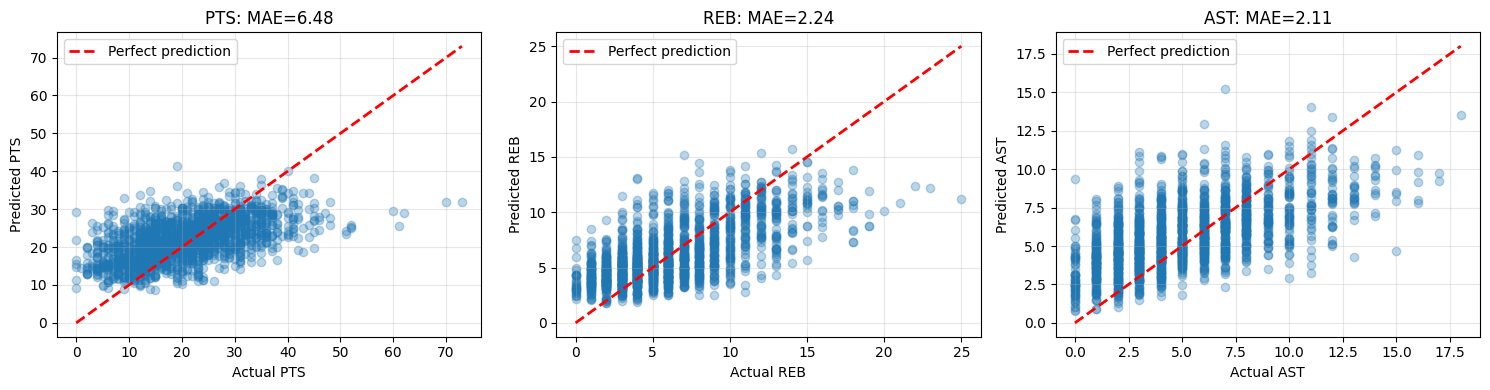

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, target in enumerate(['PTS', 'REB', 'AST']):
    ax = axes[idx]

    actuals = results[target]['actuals']
    predictions = results[target]['predictions']

    ax.scatter(actuals, predictions, alpha=0.3)
    ax.plot([actuals.min(), actuals.max()],
            [actuals.min(), actuals.max()],
            'r--', lw=2, label='Perfect prediction')
    ax.set_xlabel(f'Actual {target}')
    ax.set_ylabel(f'Predicted {target}')
    ax.set_title(f'{target}: MAE={results[target]["test_mae"]:.2f}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/predicted_vs_actual.png', dpi=150)
plt.show()

### Visualization 2: Model vs Baseline Comparison

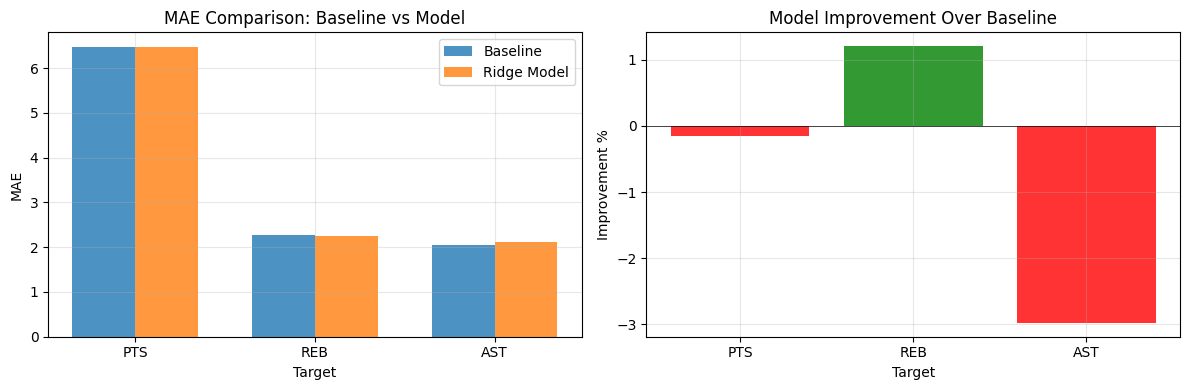


=== SUMMARY ===
Target  Baseline MAE  Model MAE  Improvement %
   PTS      6.467787   6.477940      -0.156974
   REB      2.268459   2.241111       1.205578
   AST      2.048627   2.109639      -2.978159


In [10]:
metrics_df = pd.DataFrame({
    'Target': ['PTS', 'REB', 'AST'],
    'Baseline MAE': [results[t]['baseline_mae'] for t in ['PTS', 'REB', 'AST']],
    'Model MAE': [results[t]['test_mae'] for t in ['PTS', 'REB', 'AST']],
    'Improvement %': [results[t]['improvement_pct'] for t in ['PTS', 'REB', 'AST']]
})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# MAE comparison
x = np.arange(len(metrics_df))
width = 0.35
axes[0].bar(x - width/2, metrics_df['Baseline MAE'], width, label='Baseline', alpha=0.8)
axes[0].bar(x + width/2, metrics_df['Model MAE'], width, label='Ridge Model', alpha=0.8)
axes[0].set_xlabel('Target')
axes[0].set_ylabel('MAE')
axes[0].set_title('MAE Comparison: Baseline vs Model')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_df['Target'])
axes[0].legend()
axes[0].grid(alpha=0.3)

# Improvement percentages
colors = ['green' if x > 0 else 'red' for x in metrics_df['Improvement %']]
axes[1].bar(metrics_df['Target'], metrics_df['Improvement %'], color=colors, alpha=0.8)
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Improvement %')
axes[1].set_title('Model Improvement Over Baseline')
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/model_vs_baseline.png', dpi=150)
plt.show()

print("\n=== SUMMARY ===")
print(metrics_df.to_string(index=False))

### Visualization 3: Residual Analysis

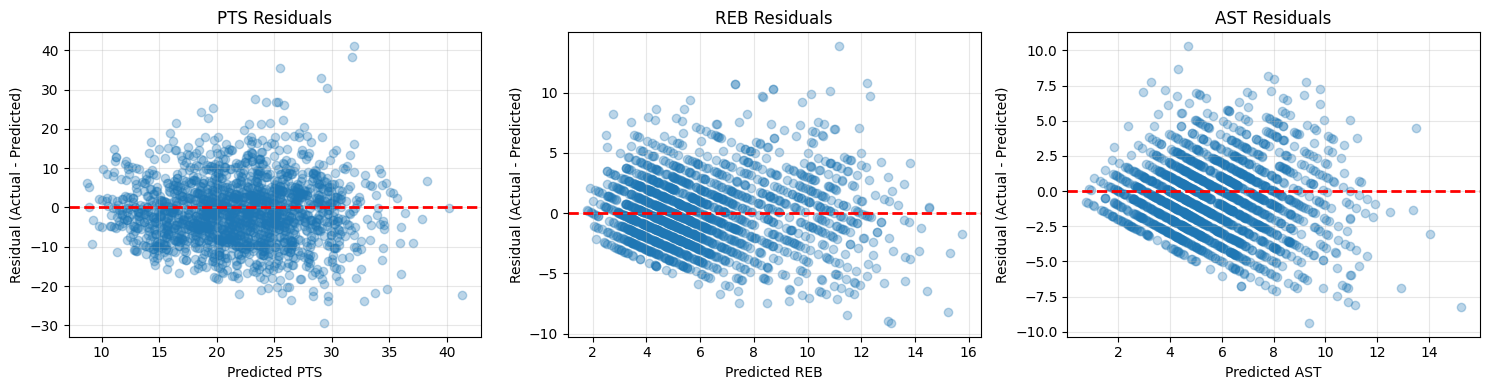

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, target in enumerate(['PTS', 'REB', 'AST']):
    ax = axes[idx]

    actuals = results[target]['actuals']
    predictions = results[target]['predictions']
    residuals = actuals - predictions

    ax.scatter(predictions, residuals, alpha=0.3)
    ax.axhline(0, color='red', linestyle='--', lw=2)
    ax.set_xlabel(f'Predicted {target}')
    ax.set_ylabel('Residual (Actual - Predicted)')
    ax.set_title(f'{target} Residuals')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/residual_analysis.png', dpi=150)
plt.show()